In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
import glob
import sys
import os
import copy
import argparse
import random
import tqdm
import time
from PIL import Image
import shutil
import subprocess
from multiprocessing import Pool

import torch
from torch.autograd import Variable


np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Import Crop GAN related libs
gan_dir = os.path.abspath("../src/")
sys.path.append(gan_dir)
from options.train_options import TrainOptions
# from options.test_options import TestOptions

from data import create_dataset
from models import create_model
import util.util_yolo as util_yolo
from models.yolo_model import Darknet
import util.util as utils
from util.dataset_yolo import ListDataset


## 1. Setup Model
The most important args to be set are:  
--checkpoints_dir:  # Set to the location of model  
--name: # the folder name 



In [ ]:

arguments = "--model double_task_cycle_gan\
             --checkpoints_dir ../data/models/ \
             --name Sythetic2bordenNight\
             --no_flip\
             --num_threads 0\
             --gpu_ids -1\
             --display_id -1\
             --preprocess resize_and_crop\
             --load_size 256\
             --crop_size 256\
             --batch_size 1 \
             --task_model_def ../src/config/yolov3-tiny.cfg" 

opt = TrainOptions().parse_notebook(arguments.split())

In [195]:
model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)               # regular setup: load and print networks; create schedulers
model.eval()


Init Resnet ... 
input_nc:  3
output_nc:  3
ngf:  64
n_blocks:  9
initialize network with normal
Init Resnet ... 
input_nc:  3
output_nc:  3
ngf:  64
n_blocks:  9
initialize network with normal
initialize network with normal
initialize network with normal

Initializing YOLO network ... 
YOLO Device:  cpu
No yolo a weights loaded 
No yolo b weights loaded 
model [DoubleTaskCycleGanModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
[Network D_A] Total number of parameters : 2.765 M
[Network D_B] Total number of parameters : 2.765 M
[Network YoloA] Total number of parameters : 8.852 M
[Network YoloB] Total number of parameters : 8.852 M
-----------------------------------------------


## 2. Load pretrained mmodel weights


In [211]:
load_suffix = "../data/models/Sythetic2bordenNight/latest"
model.load_networks_from_folder(load_suffix)

loading the model from ../data/models/Sythetic2bordenNight/latest_net_G_A.pth
loading the model from ../data/models/Sythetic2bordenNight/latest_net_G_B.pth


## 3. Load an systhetic (Domain A) image you want to transfer


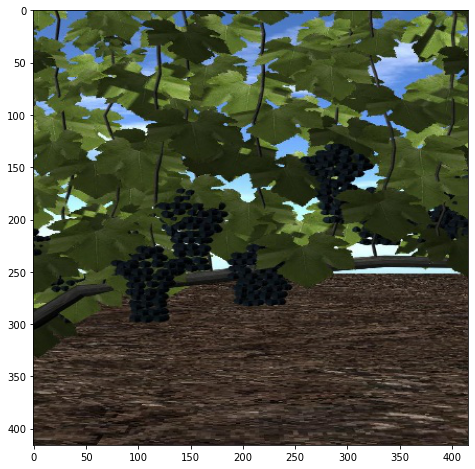

In [214]:
image_a_path = "../data/samples/sythetic/00022.jpg"
real_a_img = Image.open(image_a_path).convert('RGB')
real_a_img_tensor, real_a_img_np = utils.preprocess_images(real_a_img)
plt.imshow(real_a_img)

## 4. Generate semantically constrained GAN image


In [215]:
with torch.no_grad():
    fake_b_img = model.netG_A(real_a_img_tensor)
fake_b_img_np = fake_b_img.detach().cpu().squeeze(0).permute([1, 2, 0])*0.5+0.5

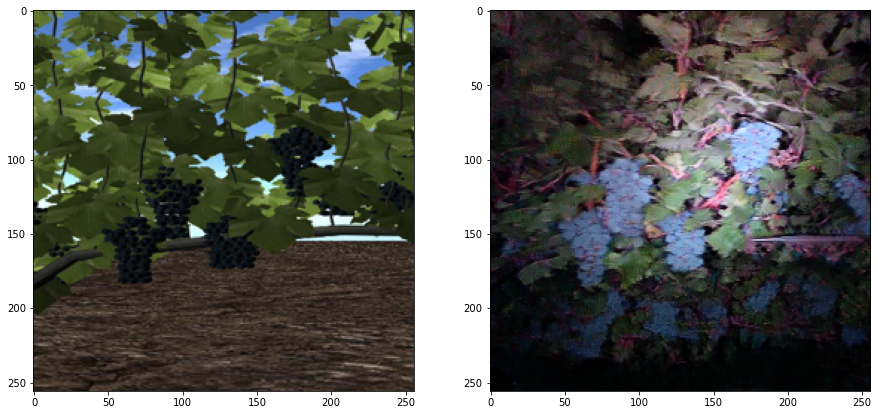

In [216]:
real_a_img_resize = real_a_img.resize([256, 256])
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(real_a_img_resize)
ax1.imshow(fake_b_img_np)
